## Plotting

In [26]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [27]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
import pandas as pd

orders_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Eniac analysis/Analysis/orders_qu.csv')
products_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Eniac analysis/Analysis/products_cl.csv')
orderlines_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Eniac analysis/Analysis/orderlines_qu.csv')
categories_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Eniac analysis/Analysis/product_category_df.csv')

Plot : Most sold products in January 17/18

In [29]:
orders_df['created_date'] = pd.to_datetime(orders_df['created_date'])

In [30]:
merged_df = orders_df.merge(orderlines_df, left_on="order_id", right_on='id_order', how='inner')
january_17 = merged_df[(merged_df['created_date'].dt.year == 2017) & (merged_df['created_date'].dt.month == 1)]
january_18 = merged_df[(merged_df['created_date'].dt.year == 2018) & (merged_df['created_date'].dt.month == 1)]
most_sold_17 = january_17.groupby("sku")['product_quantity'].sum().nlargest(10).reset_index()
most_sold_18 = january_18.groupby("sku")['product_quantity'].sum().nlargest(10).reset_index()

In [31]:
common_products = set(most_sold_17["sku"]).intersection(set(most_sold_18["sku"]))

In [32]:
common_products

{'APP0698', 'APP1190'}

In [33]:
most_sold_17["common"] = most_sold_17["sku"].isin(common_products)
most_sold_18["common"] = most_sold_18["sku"].isin(common_products)


In [ ]:
f, axs = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

In [35]:
most_sold_17['sku'] = most_sold_17['sku'].astype(str)
most_sold_18['sku'] = most_sold_18['sku'].astype(str)


Text(0, 0.5, '')

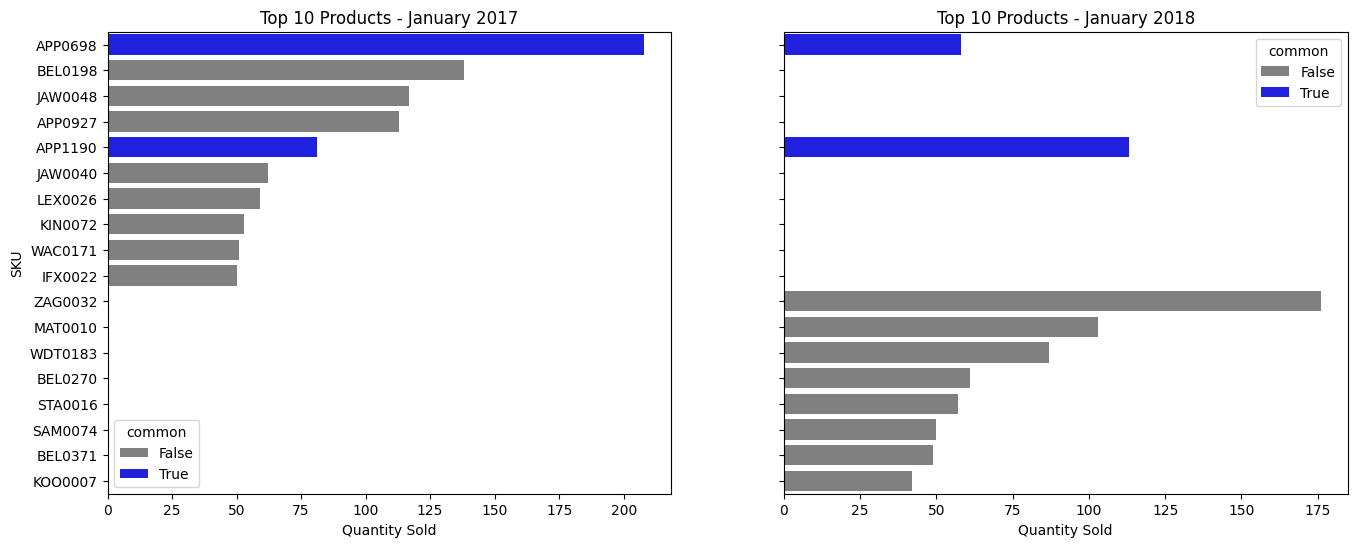

In [36]:
# Create figure and axes (two subplots side by side)
fig, axs = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Plot January 2017
sns.barplot(
    data=most_sold_17,
    x="product_quantity",
    y="sku",
    hue="common",
    dodge=False,
    palette={True: "blue", False: "gray"},
    ax=axs[0]
)
axs[0].set_title("Top 10 Products - January 2017")
axs[0].set_xlabel("Quantity Sold")
axs[0].set_ylabel("SKU")

# Plot January 2018
sns.barplot(
    data=most_sold_18,
    x="product_quantity",
    y="sku",
    hue="common",
    dodge=False,
    palette={True: "blue", False: "gray"},
    ax=axs[1]
)
axs[1].set_title("Top 10 Products - January 2018")
axs[1].set_xlabel("Quantity Sold")
axs[1].set_ylabel("")

Plot: revenue per category

In [37]:
# Merge with categories to get category name
full_df = orderlines_df.merge(categories_df, on='sku', how='left')
full_df = full_df.merge(orders_df, left_on='id_order', right_on='order_id', how='inner')

In [38]:
full_df['revenue'] = full_df['unit_price'] * full_df['product_quantity']


In [39]:
#group categories
category_summary = (
    full_df.groupby('key category', as_index=False)
    .agg({'revenue': 'sum', 'product_quantity': 'sum'})
    .rename(columns={'revenue': 'total_revenue', 'product_quantity': 'total_quantity'})
)

# Sort by revenue descending
category_summary = category_summary.sort_values('total_revenue', ascending=False)


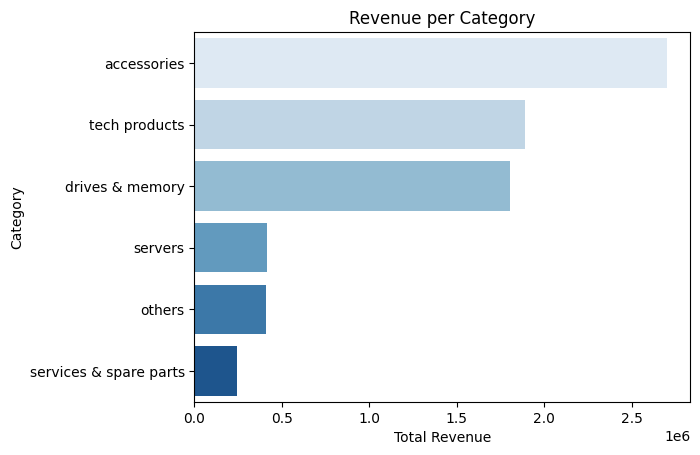

In [40]:
top6 = category_summary.head(6)
revenue_total = sns.barplot(data=top6,
                x='total_revenue',
                y='key category',
                hue='key category',
                legend=False,
                palette="Blues")
revenue_total.set_title("Revenue per Category")
revenue_total.set_xlabel("Total Revenue")
revenue_total.set_ylabel("Category");

Plot: discount per category

In [41]:
# create discount column
full_df['discount'] = (full_df['price'] - full_df['unit_price']) / full_df['price'] * 100

In [42]:
# group categories by discount
category_summary_discount = (
    full_df.groupby('key category').agg(
    total_discount=('discount', 'sum'),
    average_discount=('discount', 'mean')).reset_index()
)

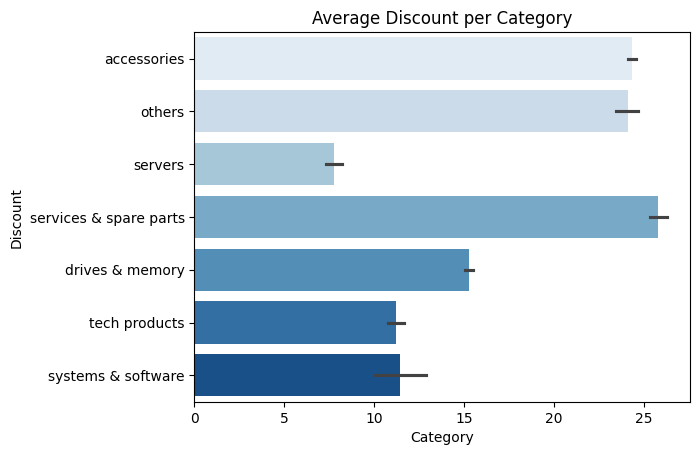

In [43]:
# assembled the needed categories
selected_categories = ['tech products', 'accessories', 'services & spare parts', 'others', 'drives & memory', 'servers', 'systems & software']
filtered_df = full_df[full_df['key category'].isin(selected_categories)]

# fig, ax1 = plt.subplots(figsize=(12,6))

# Revenue bars
average_discount_per_cat = sns.barplot(
                           data=filtered_df,
                           x='discount',
                           y='key category',
                           palette='Blues',
                           hue='key category',
                           legend=False)
average_discount_per_cat.set_ylabel('Discount')
average_discount_per_cat.set_xlabel('Category')
average_discount_per_cat.set_title('Average Discount per Category');


How many products are discounted?

In [44]:
# Calculate how many rows have unit_price < base_price
count_less = (full_df['unit_price'] < full_df['price']).sum()

# Total number of products
total = len(full_df)

# Percentage
percentage = (count_less / total) * 100

print(f"Percentage of products where unit_price < base_price: {percentage:.2f}%")


Percentage of products where unit_price < base_price: 92.81%


Plot: align those two plots next to each other

/tmp/ipython-input-2826960629.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top6,
/tmp/ipython-input-2826960629.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=filtered_df,


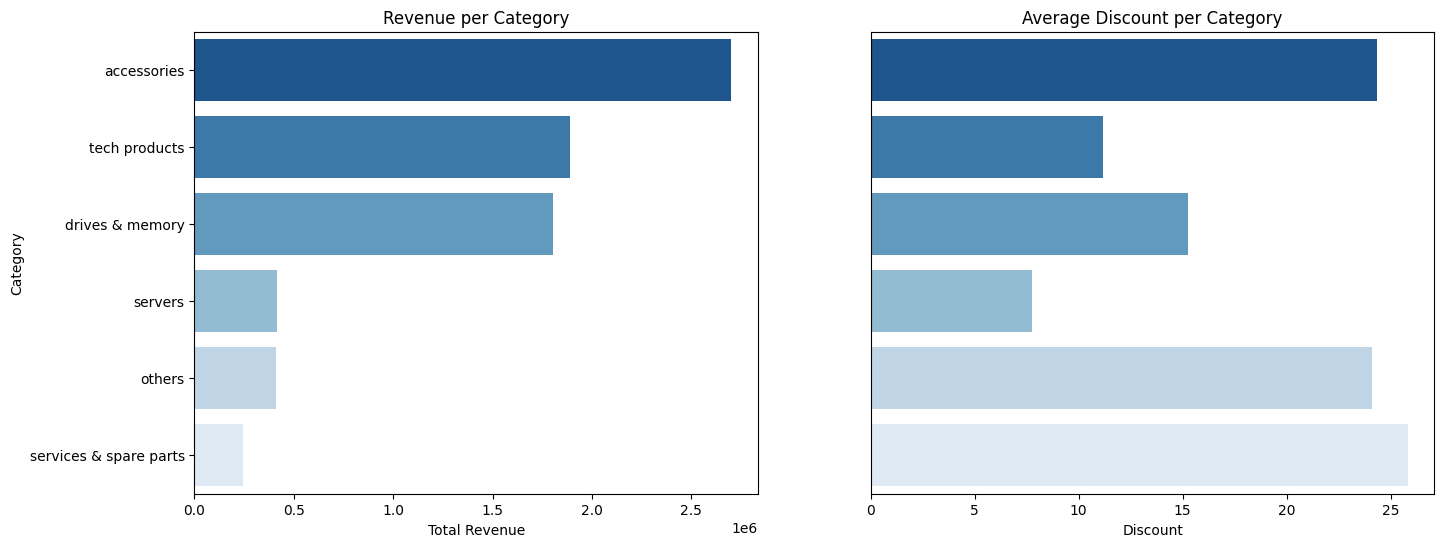

In [45]:
category_order = top6['key category']
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

colors_1 = sns.color_palette("Blues", n_colors=len(top6))[::-1]
colors_2 = sns.color_palette("Blues", n_colors=len(top6))[::-1]

# Revenue chart (left)
sns.barplot(data=top6,
            x='total_revenue',
            y='key category',
            palette=colors_1,
            order=category_order,
            #hue='key category',
            legend=False,
            ax=axes[0])
axes[0].set_title("Revenue per Category")
axes[0].set_xlabel("Total Revenue")
axes[0].set_ylabel("Category")

# Discount chart (right)
sns.barplot(data=filtered_df,
            x='discount',
            y='key category',
            palette=colors_2,
            order=category_order,
            errorbar=None,
            #hue='key category',
            legend=False,
            ax=axes[1])
axes[1].set_title("Average Discount per Category")
axes[1].set_xlabel("Discount")
axes[1].set_ylabel("")

axes[1].set_ylabel("")
axes[1].set_yticklabels([])
axes[1].tick_params(axis='y', left=False);


Plot: Average sales price per discount range

/tmp/ipython-input-2097831045.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  revenue_summary = full_df.groupby('discount_band')['unit_price'].mean().reset_index()


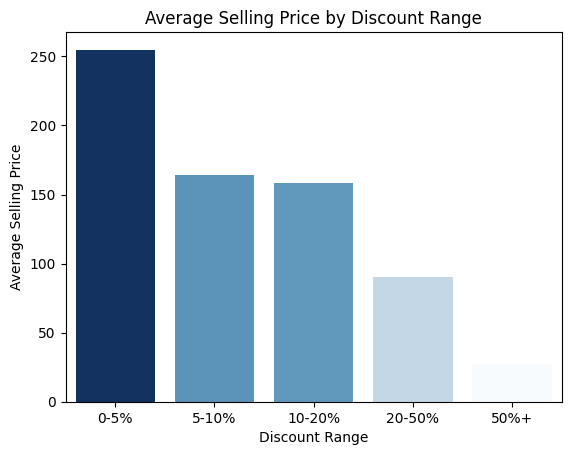

In [46]:
# Create discount bands
bins = [0, 5, 10, 20, 50, 100]
labels = ['0-5%', '5-10%', '10-20%', '20-50%', '50%+']
full_df['discount_band'] = pd.cut(full_df['discount'],
                                  bins=bins,
                                  labels=labels,
                                  right=False)

# Average revenue per band
revenue_summary = full_df.groupby('discount_band')['unit_price'].mean().reset_index()
revenue_summary.rename(columns={'unit_price': 'avg_selling_price'}, inplace=True)

# Plot

sales_price_range = sns.barplot(data=revenue_summary,
                                x='discount_band',
                                y='avg_selling_price',
                                palette='Blues',
                                hue='avg_selling_price',
                                legend=False,)
sales_price_range.set_title('Average Selling Price by Discount Range')
sales_price_range.set_xlabel('Discount Range')
sales_price_range.set_ylabel('Average Selling Price');


Plot: Price distribution per discount band

/tmp/ipython-input-4263346147.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  price_distr_per_band = sns.boxplot(data=full_df,


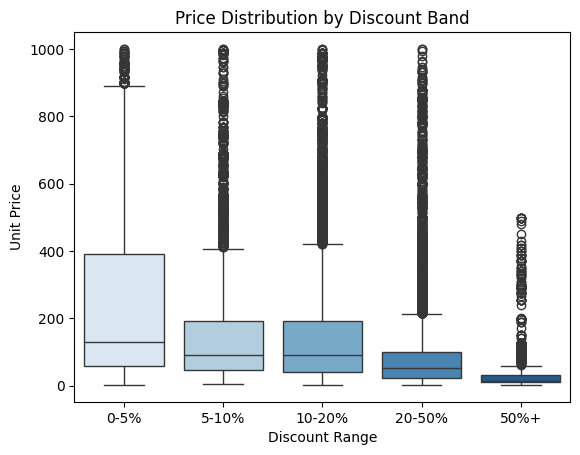

In [58]:
# Plot price distribution per discount band
price_distr_per_band = sns.boxplot(data=full_df,
                                   x='discount_band',
                                   y='unit_price',
                                   palette='Blues')
price_distr_per_band.set_title('Price Distribution by Discount Band')
price_distr_per_band.set_xlabel('Discount Range')
price_distr_per_band.set_ylabel('Unit Price');



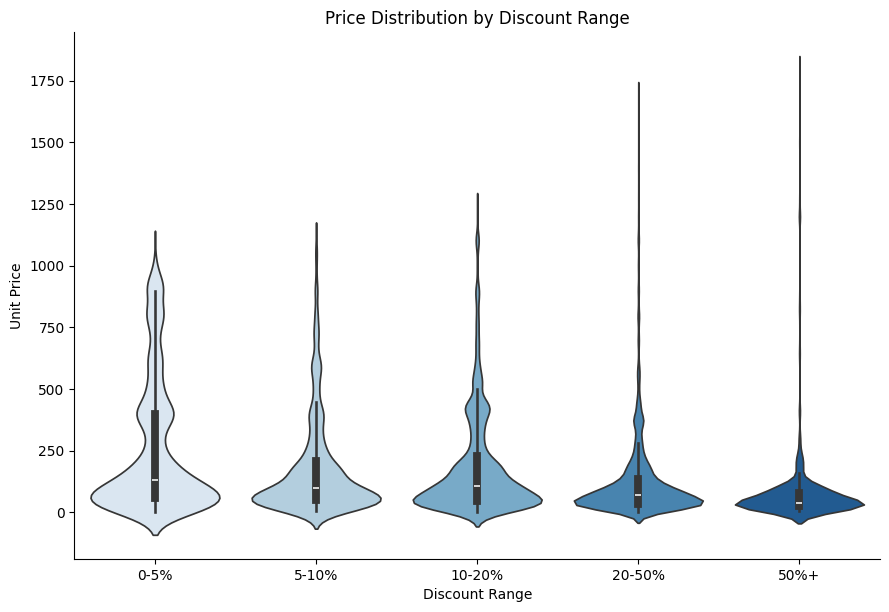

In [48]:
price_discount = sns.catplot(data=full_df,
                          x='discount_band',
                          y='price',
                          kind='violin',
                          hue='discount_band',
                          legend=False,
                          height=6,
                          aspect=1.5,
                          palette="Blues"
            )
price_discount.ax.set_title('Price Distribution by Discount Range')
price_discount.set_axis_labels('Discount Range', 'Unit Price')

Share of orders per Discount Range

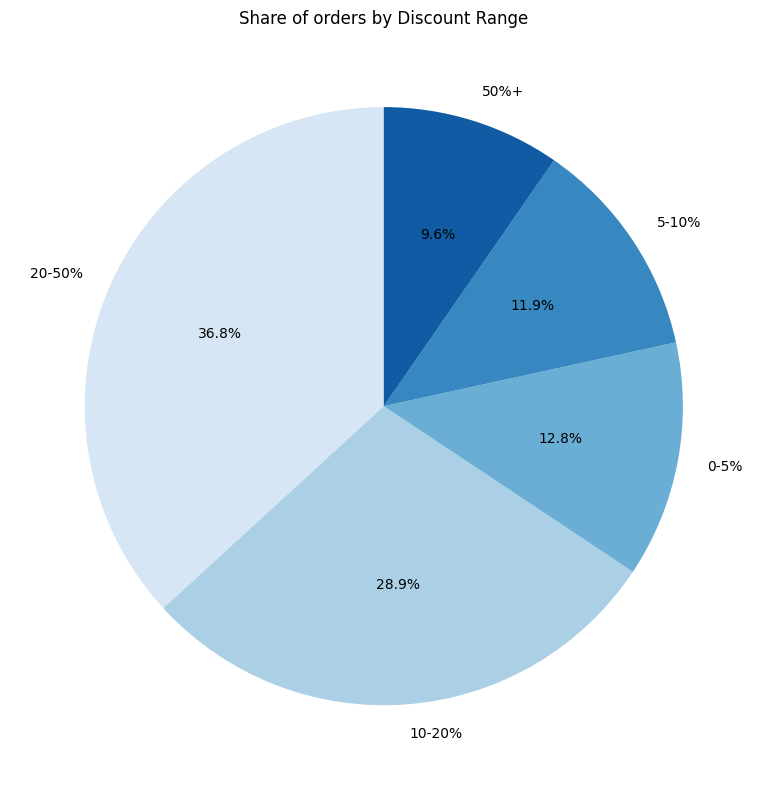

In [49]:
discount_counts = full_df['discount_band'].value_counts().reset_index()
discount_counts.columns = ['discount_band', 'count']

plt.figure(figsize=(8,8))
plt.pie(
    discount_counts['count'],
    labels=discount_counts['discount_band'],
    autopct='%1.1f%%',
    startangle=90,
    colors=sns.color_palette("Blues", n_colors=len(discount_counts))
)
plt.title('Share of orders by Discount Range')
plt.tight_layout()
plt.show()


Average selling price per tech product

In [59]:
# Filter for the category
tech_df = full_df[full_df['key category'] == 'tech products']

# Compute average selling price
avg_selling_price = tech_df['unit_price'].mean()

print(f"Average selling price for Tech Products: ${avg_selling_price:.2f}")


Average selling price for Tech Products: $524.15


Revenue and discount per category

In [60]:
revenue_summary

,discount_band,avg_selling_price
0,0-5%,254.857536
1,5-10%,163.943197
2,10-20%,158.105577
3,20-50%,90.274186
4,50%+,27.564062


In [61]:
top6

,key category,total_revenue,total_quantity
0,accessories,2700236.38,31239
18,tech products,1887425.45,3598
6,drives & memory,1805909.25,13030
11,servers,412999.57,1047
8,others,411983.10,3808
12,services & spare parts,243994.05,5317


/tmp/ipython-input-1224254261.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


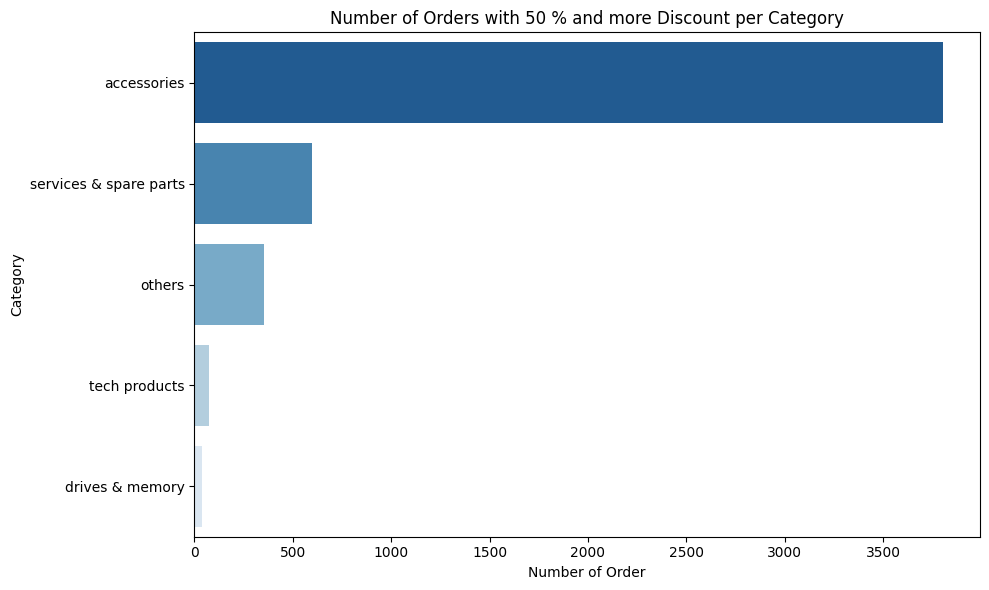

In [65]:
# Filter to selected categories
filtered_df = full_df[full_df['key category'].isin(selected_categories)]

# Filter for the 50%+ discount band
high_discount_df = filtered_df[filtered_df['discount_band'] == '50%+']

# Count how many orders in each category have 50%+ discounts
high_discount_counts = (
    high_discount_df.groupby('key category')
    .size()
    .reset_index(name='order_count')
    .sort_values('order_count', ascending=False)
)
colors = sns.color_palette("Blues", n_colors=len(high_discount_counts))[::-1]
# Plot
plt.figure(figsize=(10,6))
sns.barplot(
    data=high_discount_counts,
    x='order_count',
    y='key category',
    palette=colors,
    errorbar=None
)
plt.title('Number of Orders with 50 % and more Discount per Category')
plt.xlabel('Number of Order')
plt.ylabel('Category')
plt.tight_layout()
plt.show()


/tmp/ipython-input-1948521266.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['key category', 'discount_band'])


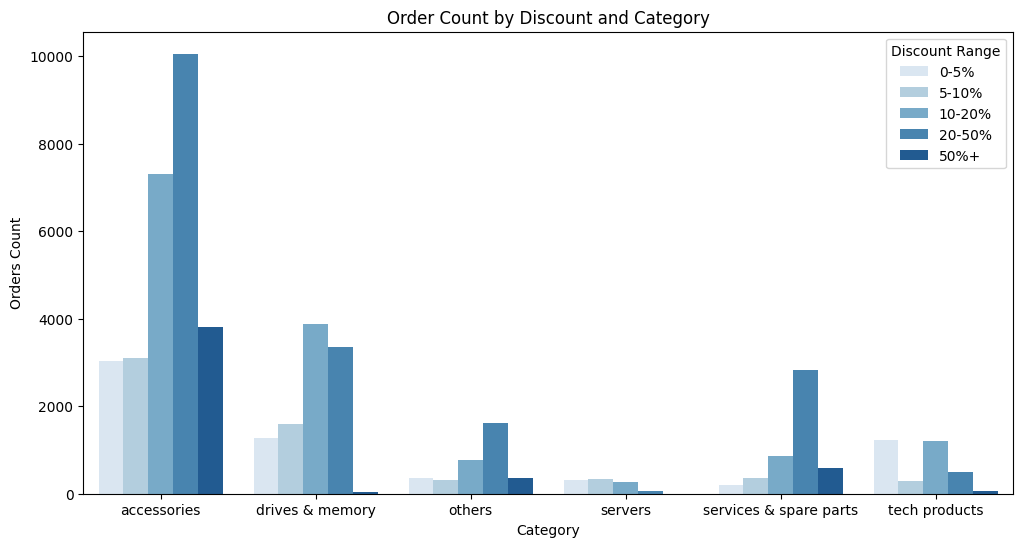

In [67]:
# Keep only your selected categories
filtered_df = full_df[full_df['key category'].isin(selected_categories)]

# Count orders by category and discount band
discount_category_summary = (
    filtered_df
    .groupby(['key category', 'discount_band'])
    .size()
    .reset_index(name='order_count')
)

# Plot
plt.figure(figsize=(12,6))
order_discount_category = sns.barplot(
    data=discount_category_summary,
    x='key category',
    y='order_count',
    hue='discount_band',
    palette='Blues'
)
order_discount_category.set_title('Order Count by Discount and Category')
order_discount_category.set_xlabel('Category')
order_discount_category.set_ylabel('Orders Count')
# plt.xticks(rotation=45)
order_discount_category.legend(title='Discount Range')
# plt.tight_layout()
# plt.show()

/tmp/ipython-input-506022932.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['key category', 'discount_band'], as_index=False)['revenue']


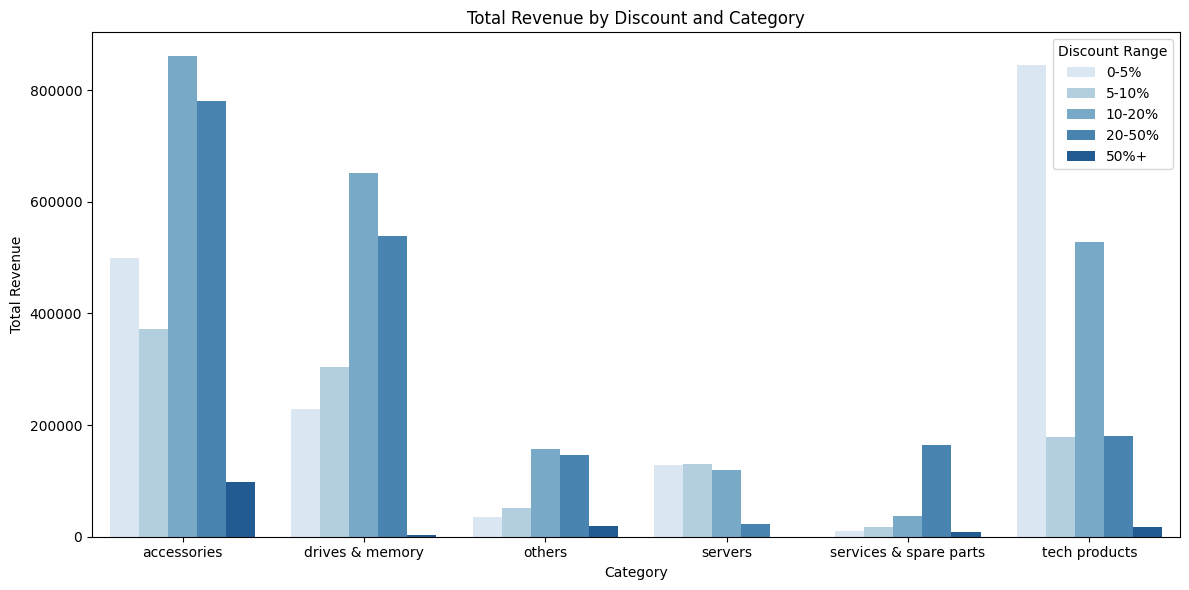

In [68]:
filtered_df = full_df[full_df['key category'].isin(selected_categories)]

# Sum revenue by category and discount band
discount_category_summary = (
    filtered_df
    .groupby(['key category', 'discount_band'], as_index=False)['revenue']
    .sum()
    .rename(columns={'revenue': 'total_revenue'})
)

# Plot
plt.figure(figsize=(12,6))
ax = sns.barplot(
    data=discount_category_summary,
    x='key category',
    y='total_revenue',
    hue='discount_band',
    palette='Blues'
)
ax.set_title('Total Revenue by Discount and Category')
ax.set_xlabel('Category')
ax.set_ylabel('Total Revenue')
ax.legend(title='Discount Range')
plt.tight_layout()
plt.show()
